# QUANTUM-POWERED PLANNER FOR EV CHARGING NETWORKS
### Greening the road ahead: Charging demand location model for sustainable electric vehicle adoption.

Quantum computers based on neutral atoms have introduced novel approaches to solving complex problems in combinatorial optimization. While many applications focus on encoding problems as maximal independent set (MIS) formulations, these devices can handle even more challenging tasks by utilizing the Rydberg blockade mechanism, allowing us to address non-linearities in problem formulations.



This quantum methodology aligns perfectly with our objective of optimizing electric vehicle (EV) charging network (EVCN) within urban environments. These settings present complex challenges, where multiple factors, including population density, traffic patterns, existing infrastructure, and EV adoption rates, introduce non-linear complexities into the equation.



Our solution builds upon this foundation, by harnessing Pasqal's quantum computing technology, our approach seeks to efficiently resolve the complexities of charging station placement in urban settings, leveraging the power of quantum annealing techniques in neutral atoms architectures to determine the optimal solution effectively. 

We have shown the results of the EVCN problem for the quantum adiabatic algorithm (QAA) and the quantum approximate optimization algorithm (QAOA) for instances up to 13 qubits. We present results for 5 random instances of each problem size. The results are encouraging as the probability of finding the 5 best solutions to each problem is above a quadratic speedup without deep finetuning.


This platform is highly adaptable and can be tailored to any complex local context where users provide input data. In doing so, it contributes significantly to the transition toward a net-zero emission transport economy, addressing sustainable urban mobility challenges on a broader scale.


## Needed Libraries

In [1]:
import numpy as np
import networkx as nx
import time
from docplex.mp.model import Model # CPLEX solver
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.optimize import minimize
import pandas as pd

In [2]:
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import Chadoq2
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

In [3]:
%matplotlib inline

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.autolayout'] = False
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['lines.markersize'] = 7
mpl.rcParams['lines.markeredgewidth'] = 1.2
mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 6
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 6
mpl.rcParams['legend.fontsize'] = 17
mpl.rcParams['mathtext.fontset'] = 'dejavusans'
mpl.rcParams['font.family'] = 'sans-serif'

colors = mpl.cm.get_cmap("coolwarm", 20)


/var/folders/76/d4kyjysx1xgdrrs6zzs63s180000gn/T/ipykernel_6835/2308717790.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap("coolwarm", 20)


## EVCN Model

Our proposed solution starts from the well-known maximal independent set (MIS) problem, with the cost function

$$Cost(x) = -\sum_i x_i + 2\sum_{(i,j) \in E}x_i x_j$$ 

where $x_i$ represent all the possible charging station locations. If $x_i$ = 1, a charging station is present at the location $x_i$. The second term in the cost function represents the penalization of two neighboring locations both being occupied simultaneously. The solution to this problem will represent a maximal set of EV charging stations that are not close to each other, therefore maximizing the coverage of the network.

The MIS is an oversimplification of the EVCN model and different factors such as population density, traffic patterns, existing infrastructure, and EV adoption rates must be taken into account. For example, these factors can make two neighboring locations being better suited than just one of them. Therefore, we propose a new formulation given by  

$$Cost(x) = x^TQx = -\sum_i x_i + \sum_{(i,j)\in E}\lambda_{i,j} x_i x_j$$ 

where $\lambda_{ij}$ not only represents a penalization of the connected locations but additionally it represents other factors, including population density, traffic patterns, existing infrastructure, and EV adoption rates. They also represent the off-diagonal values of the quadratic unconstrained binary optimization (QUBO) matrix $Q$, which can be solved on a neutral atom device.

We assume a linear relation between the demand on two neighboring locations and the penalizations $\lambda_{ij}$. The cutoff charging demand values in the following text are selected as such for illustration purposes. We will scale them appropriately in a real-world implementation. In this example, we work with a demand $\delta_{i}$ arbitrary units for every location. If the sum of demands on two neighboring locations, $\delta_{T_{ij}}$, is less than $\delta_{min}$, the penalization is $\lambda_{max}$ (equal to the MIS). If the demand is between $\delta_{min}$ and $\delta_{max}$, the penalization will change proportionally to the demand, and if it is above $\delta_{max}$, a minimum penalization is used, i.e., $\lambda_{min}$.

\begin{equation}
\lambda_{i,j}(\delta_T) =
\begin{cases}
  \lambda_{max} & \text{if } \delta_{T_{ij}} < \delta_{min} \\
  m \delta_{T_{ij}} + b & \text{if } \delta_{min} \le \delta_{T_{ij}} \le \delta_{max} \\
  \lambda_{min} & \text{if } \delta_{T_{ij}} > \delta_{max}  \\
\end{cases}
\end{equation}

where $\delta_{i(j)}$ represents the demand at location $i(j)$, and $\delta_{T_{ij}} = \delta_i + \delta_j$ the sum of local demnads at postions $i$ and $j$. 

$$m = \frac{\lambda_{min} - \lambda_{max}}{\delta_{max} - \delta_{min}}$$

$$b = \lambda_{min} - m \delta_{max}$$



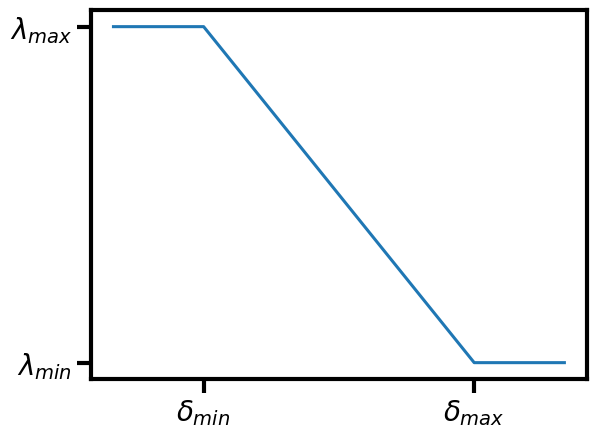

In [4]:
fig, ax = plt.subplots()
ax.plot([0, 3, 12, 15], [5,5,1,1])
ax.set_yticks([1, 5])
ax.set_yticklabels([r"$\lambda_{min}$", r"$\lambda_{max}$"])
ax.set_xticks([3, 12])
ax.set_xticklabels([r"$\delta_{min}$", r"$\delta_{max}$"])
fig.savefig("./Figures/lambda_ij.png", bbox_inches="tight")

In [7]:
def graph(num_qubits, distance_threshold=1.5):
    """ Create a networkx graph with a squared layout based on the number of qubits.
        Args:
        num_qubits (int): Number of atoms used in the model
        distance_threshold (float): maximum distance to consider two charging locations are connected.
                            default (1.5): This value consider diagonal points connected
        Return:
        G (networkx graph): the square grid graph
    """
    grid = round(np.ceil(np.sqrt(num_qubits))) # Grid size for the number of atoms
    G = nx.Graph()
    pos = []
    # Adding atoms to the grid
    for i in range(grid):
        for j in range(grid):
            if len(pos) < num_qubits:
                pos.append([i, j])
            else:
                break
    # Save the position of the atoms
    pos = np.array(pos)
    for i, point1 in enumerate(pos):
        G.add_node(i, pos=tuple(point1))

    # Define a distance threshold for considering neighbors
    # Connect near neighbors based on the distance threshold
    for i, point1 in enumerate(pos):
        for j, point2 in enumerate(pos):
            if i != j and np.linalg.norm(point1 - point2) <= distance_threshold:
                G.add_edge(i, j)
    return G
            

def lambda_fun(deltaT, delta_min=5, delta_max=25, lambda_min=0.3, lambda_max=2):
    """Penalization function of neighboring locations.
        Args:
        deltaT: (int/float) sum of the demand in the locations i and j
        delta_min: (int/ float) minimum demand considered
        delta_max: (int/ float) maximum demand considered
        lambda_max: maximum penalization 
        lambda_min: minimum penalization
        
        Return:
            lambda_ij: (float) Penalization for the given demand
        
    """
    if deltaT < delta_min:
        return lambda_max
    elif deltaT >= delta_min and deltaT <= delta_max:
        m = (lambda_min - lambda_max)/(delta_max - delta_min)
        b = lambda_min - m * delta_max
        return round(m * deltaT + b, 2)
    else:
        return lambda_min
    
def set_problem(G, demand, strength=10):
    """ Return the lambda_ij terms and the Q matrix from a given graph and demand
        Args:
        G (networkx graph): Graph that represent the EV charing locations
        demand (Array): Demand at each EV charing location.
        strength (float): Amplification of the signal to agree with the interaction between atoms.
        
        Return:
        lambda_ij (dict): keys:(location_1, location_2) Values: value
        Q (np.array): Q matrix of the QUBO.
    
    """
    pos = nx.get_node_attributes(G, 'pos')
    Q = - strength * np.eye(len(G.nodes))
    demand_dict = {}
    lambda_ij = {}
    for p1, p2 in G.edges:
        p1_xy = pos[p1]
        p2_xy = pos[p2]
        DT = demand[pos[p1]] + demand[pos[p2]]
        demand_dict[(p1, p2)] = DT
        lambda_ij[(p1, p2)] = lambda_fun(DT)
        Q[p1,p2] = (1/2) * strength * lambda_ij[(p1, p2)]
        Q[p2,p1] = (1/2) * strength  * lambda_ij[(p1, p2)]
    return lambda_ij, Q

## Example: EVCN for 8 locations in a 3 x 3 grid

In [8]:
n_qubits = 8 # Locations
grid = round(np.ceil(np.sqrt(n_qubits))) # grid size for a square location
G = graph(n_qubits, distance_threshold=1.5) # Setting the grid in a networkx graph
pos = nx.get_node_attributes(G, 'pos') # Position of the charging locations

seed = 12
np.random.seed(seed)
demand_min = 3
demand_max = 14
# Choosing the demand to be random. In the future, it will be calculated using real data.

demand = np.random.choice(range(demand_min, demand_max+1), size=(grid, grid)) 
lambda_ij, Q = set_problem(G, demand) #penalization strength of the QUBO, Q matrix of the QUBO

### Visualization of the problem

In the figure below, we show the problem we use in our example. The background on the left figure shows the demand at each location, with a darker red representing higher demand, the vertices representing the EV locations, and the edges representing the locations that are close to each other. The figure on the right shows the same problem but in this case, the color of the edges represents the $\lambda_{ij}$ strength with a red color representing a high penalization and a dark blue a small one. For example, $\lambda_{0,1} = 0.3$ is a small penalization because in locations 0 and 1 there is a high demand, and $\lambda_{3,7}=1.83$ is a large penalization because in locations 3 and 7 there is a small demand.

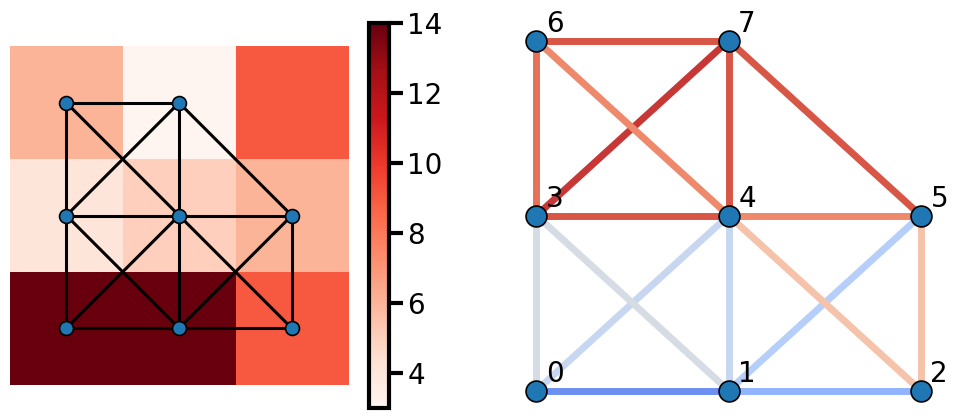

In [11]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax1 = ax[0].imshow(demand, cmap="Reds", origin='lower')

for p1, p2 in G.edges:
    x = [pos[p1][1], pos[p2][1]]
    y = [pos[p1][0], pos[p2][0]]
    ax[0].plot(x, y, color="black")
for xy in pos.values():
    ax[0].plot(xy[1], xy[0], marker="o", color="tab:blue", markersize = 10, markeredgecolor="black")
fig.colorbar(ax1)

for p1, p2 in G.edges:
    x = [pos[p1][1], pos[p2][1]]
    y = [pos[p1][0], pos[p2][0]]
    ax[1].plot(x, y, color=colors(round(10 * lambda_ij[(p1, p2)])), linewidth=5)

for nn, xy in pos.items():
    ax[1].plot(xy[1], xy[0], marker="o", color="tab:blue", markersize = 15, markeredgecolor="black")
    ax[1].text(xy[1]+0.05, xy[0]+0.05, nn)
for i in range(2):
    ax[i].axis('off');
fig.savefig("./Figures/setup_exp.png", bbox_inches="tight")

### Docplex model

Docplex is the Python interface of the IBM's CPLEX solver, a widely used solver for combinatorial optimization problems. This solver is highly efficient in solving linear programming and quadratic programming problems using state of the art optimization techniques. We will use this classical optimizer to find the optimal solution for our examples, as well as, to show the scalability properties of our task on classical solvers.

In [12]:
def MIS(G, strength=10):
    """Maximal indepdent set problem on CPLEX.
    Args:
        G (networkx.Graph): Graph with charging locations as nodes and penalization because of close locations 
                            as edges.
        strength (float): Amplification of the signal to agree with the interaction between atoms. 
    
    Return:
        mdl (docplex.model.Model): CPLEX model of the problem.
    """
    mdl = Model("MIS") # Create the problem 
    x = mdl.binary_var_list(len(G.nodes), name="x") # Variables of the problem.
    cost = 0 # Objective function
    cost -= mdl.sum(x)
    for i, j in G.edges:
        cost += 2 * x[i] * x[j] # penalization of neighbor charging locations
    mdl.minimize(cost) # minimization of the cost function
    return mdl

def EVCN(G, lambda_ij, strength=10):
    """Electrical-Vehicle Charing Networks model
    Args: 
        G (networkx.Graph): Graph with charging locations as nodes and penalization because of close locations 
                            as edges.
        lambda_ij (dict): Dict with values as the edges and values the modification of the penalization to 
                          consider other factors such as demand.
        strength (float): Amplification of the signal to agree with the interaction between atoms.
    
    Return:
        mdl (docplex.model.Model): CPLEX model of the problem.
    """
    mdl = Model("EVCN") # Create the CPLEX model
    x = mdl.binary_var_list(len(G.nodes), name="x") # Variables (Charging locations) 
    cost = 0
    cost -= strength * mdl.sum(x)
    for i, j in G.edges:
        cost += strength * lambda_ij[i,j] * x[i] * x[j]
    mdl.minimize(cost) # minimize the objective function.
    return mdl

In [13]:
# Model of the electric vehicle charging network 
mdl = EVCN(G, lambda_ij)
mdl.prettyprint() # visualization of the problem
mdl.solve() # solving the problem

opt_sol = [round(mdl.solution.get_value(var)) for var in mdl.iter_binary_vars()] # get back the solution

print(f"The optimal value is : {round(mdl.solution.objective_value,3)}")
print(f"The optimal solution is : {opt_sol}")

// This file has been generated by DOcplex
// model name is: EVCN
// var contrainer section
dvar bool x[8];

minimize
 - 10 x_0 - 10 x_1 - 10 x_2 - 10 x_3 - 10 x_4 - 10 x_5 - 10 x_6 - 10 x_7 [
 3 x_0*x_1 + 9 x_0*x_3 + 8.100000 x_0*x_4 + 4.700000 x_1*x_2 + 9 x_1*x_3
 + 8.100000 x_1*x_4 + 7.300000 x_1*x_5 + 12.300000 x_2*x_4 + 11.500000 x_2*x_5
 + 16.600000 x_3*x_4 + 15.800000 x_3*x_6 + 18.300000 x_3*x_7
 + 14.900000 x_4*x_5 + 14.900000 x_4*x_6 + 17.400000 x_4*x_7
 + 16.600000 x_5*x_7 + 16.600000 x_6*x_7 ];
 
subject to {

}
The optimal value is : -32.3
The optimal solution is : [1, 1, 1, 0, 0, 0, 1, 0]


### Visualization of the solution

The Figure below shows the optimal solution for our example. The red dots represent the locations used as charging stations. Note that in this case, two neighboring locations can be selected at the same time, this is the outcome of considering that multiple factors affect the model, and not only the distance between possible charging station locations.

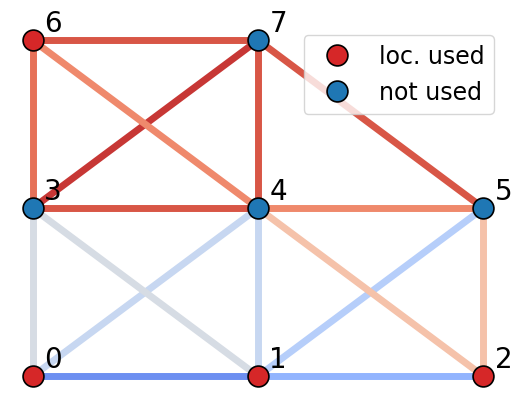

In [14]:
fig, ax = plt.subplots()
demand_dict = {}
lambda_ij = {}
for p1, p2 in G.edges:
    p1_xy = pos[p1]
    p2_xy = pos[p2]
    DT = demand[tuple(pos[p1])] + demand[tuple(pos[p2])]
    demand_dict[(p1, p2)] = DT
    lambda_ij[(p1, p2)] = lambda_fun(DT)
    x = [pos[p1][1], pos[p2][1]]
    y = [pos[p1][0], pos[p2][0]]
    ax.plot(x, y, color=colors(round(10* lambda_ij[(p1, p2)])), linewidth=5)
for ii, xy in pos.items():
    if opt_sol[ii]:
        ax.plot(xy[1], xy[0], marker="o", color="tab:red", markersize = 15, markeredgecolor="black")
    else:
        ax.plot(xy[1], xy[0], marker="o", color="tab:blue", markersize = 15, markeredgecolor="black")
    ax.text(xy[1]+0.05, xy[0]+0.05, ii)
ax.plot([],[], marker="o", linewidth=0, color="tab:red", markeredgecolor="black", label="loc. used", markersize=15)
ax.plot([],[], marker="o", linewidth=0, color="tab:blue", markeredgecolor="black", label="not used", markersize=15)

ax.legend()
ax.axis('off');
fig.savefig("./Figures/sol_8q_exp.png", bbox_inches="tight")

### Classical solution using brute force

Below, we show the brute force solution of the model consists of trying all the possible solutions. As this method grows as $2^n$ for $n$ charging station locations, it becomes prohibitively even for small problem sizes.

In [15]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
sols_brute = [i[0] for i in sort_zipped[:3]]
cost_min = sort_zipped[0][1] # minimum cost used for the approximation ratio
cost_max = sort_zipped[-1][1]# maximum cost used for the approximation ratio
print("The 3 best solutions:", sort_zipped[:3])
print("Worst solution:", sort_zipped[-1])

The 3 best solutions: [('11100001', -32.3), ('11100010', -32.3), ('10000110', -30.0)]
Worst solution: ('11111111', 124.1)


### Finding the neutral atoms' positions

Once we have set the problem of the EVCN. The next step is to find the position of the atoms that represent the problem. To this end, we start with the position of the atoms based on the graph above as the initial guessing and use the $Powell$ optimization method to find the best coordinates that represent the matrix $Q$. 

In [16]:
def evaluate_mapping(new_coords, Q, backend=Chadoq2):
    """ Evaluation how well the set of coordinates 'new_coords' represent the matrix Q.
    
        Args:
        new_coords (1D Array): Guessing coordinates of the neutral atoms positions
        Q (2D array): Matrix with the encoded information of the EVCN
        
        Return:
        cost (float): value of the difference between the matrix Q of the problem and the matrix Q based 
                      on the guessing coordinates of the neutral atoms
    """
    shape = Q.shape
    new_coords = new_coords.reshape(len(Q), 2)
    new_Q = squareform(backend.interaction_coeff / (pdist(new_coords) ** 6 + 1e-6)) # Q based on the guessing position of the atoms
    cost = 0 
    for i in range(shape[0]):
        for j in range(i+1, shape[0]):
            cost += (Q[i,j] - new_Q[i,j]) ** 2 # minimize the square of the off-diagonal elements of the Q matrix and 
                                               # the new_Q matrix of the guessing position of the atoms. 
    return cost

def get_layout(Q, pos, print_output=True, seed=0):
    """ Method to find the best set of coordinates of the neutral atoms to represent the matrix Q.
        
        Args:
            Q (np.array(nq, nq)): QUBO matrix Q of the EVCN
            pos (list (nq, 2)): position of the different charging stations
        Return:
            coords: list of coordinates of the atoms to represent the matrix Q
        
    """
    shape = (len(Q), 2)
    np.random.seed(seed)
    x0 = np.array(list(pos.values()))
    x0 = (x0 - x0.mean(axis=0)).flatten() # preprocessing the data of the position of the atoms to put them around zero
    res = minimize(
        evaluate_mapping,
        x0,
        args=(Q),
        method="Powell",
        tol=1e-6,
        options={"maxiter": 20000, "maxfev": None},
    )
    if print_output:
        print(f"Cost function {res.fun}| Iterations used: {res.nfev}")
    coords = np.reshape(res.x, (len(Q), 2))
    return coords

In [17]:
coords = get_layout(Q, pos, seed=0) # coordinates of the qubits
qubits = dict(enumerate(coords))
reg_8q = Register(qubits) # Pulser Register

Cost function 88.92814651517817| Iterations used: 2424


### Final register

Here, we create the final pulser register based on the coordinates found for the Q matrix of the 8 charging location positions.

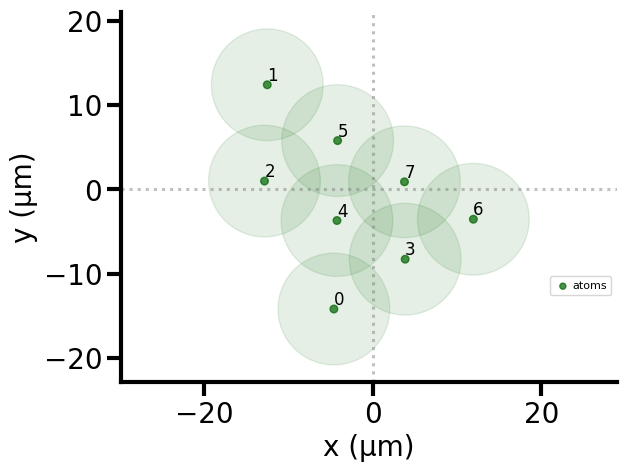

In [21]:
fig, ax = plt.subplots()
reg_8q.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
    custom_ax = ax
)
fig.savefig("./Figures/atoms_pos.png", bbox_inches="tight")

## Solving the problem using Quantum Algorithms

We use two different optimizer to find solutions to the problem, the quantum adiabatic algorithm (QAA) and the quantum approximate optimization algorithm (QAOA). To test the capabilities of the methods to find good solutions we use two methods, calculate the success probability to find the optimal solution $p(^* x)$ and the approximation ratio $r$ to get the average cost of the probability distribution. The approximation ratio is given by

$$r = \frac{\langle H_C \rangle - \langle H_{max} \rangle}{\langle H_{min} \rangle - \langle H_{max} \rangle},$$

where $\langle H_C \rangle$ is the cost of the samples evaluated, $\langle H_{min} \rangle$ is the minimum energy, and $\langle H_{max} \rangle$ is the maximum energy. A value of $r=1$ means a 100\% probability of getting the optimal solution.

In [22]:
def run_algorithm(assigned_seq, n_samples=1000, seed=123):
    """run the circuit simulating the evolution of the neutral atoms' device
    
        Args: 
        assigned_seq (pulser.Sequence): Sequence of the quantum algorithm, e.g, QAA or QAOA
        n_samples (int): Number of samples to get
        seed (int): Seed to see reproducible results
        
        Return:
        count_dict (dict): samples return by the algorithm, keys: strings values: counts
    """
    np.random.seed(seed)
    simul = QutipEmulator.from_sequence(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state(N_samples=n_samples)  # sample from the state vector
    return count_dict

def get_cost_QUBO(bitstring, Q):
    """Evaluate the cost function"""
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost

def mean_cost(counter, Q):
    """ Mean value of the cost for some samples"""
    cost = sum(counter[key] * get_cost_QUBO(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

def approximation_ratio(counter, Q, min_energy, max_energy):
    """Aproximation ratio"""
    mean_energy = mean_cost(counter, Q)
    r = (mean_energy - max_energy)/ (min_energy - max_energy)
    return r

# QAOA Solution

In our QAOA solution for the EVCN problem, we introduce a novel technique known as 'transfer learning.' This approach uses preoptimized parameters obtained from a distinct problem. In our case, the parameters we use come from a completely different problem called the Bin Packing Problem (BPP), and they were obtained in the gate-based QAOA for p=10, (we will show this technique more in deep in a paper coming soon). To the best of our knowledge, this is the first time that a technique like this has been applied to neutral atoms' protocols. This technique significantly reduces the need for classical optimization when solving a given problem.

Additianlly, we encode the $\gamma$ and $\beta$ parameters in the amplitude of $\delta$ and $\Omega$, respectively. Previous efforts, encode the $\gamma$ and $\beta$ parameters in the duration of the pulses keeping $\Omega$ and $\delta$ amplitude constant. However, it representes a longer schedule time, we jump from a time of $100\mu s$ with the previous encoding to $1\mu s$ with the proposed modification, and we get comparable results in terms of the quality using both methods. 


In [23]:
def QAOA(betas, gammas, reg, pulse_width = 52, Omega_max=7.5, delta_max = 10.0, backend=Chadoq2):
    """ Quantum Approximate Optimization Algorithm
        Args:
            betas (list): parameters of the mixer Hamiltonian
            gammas (list): parameters of the problem Hamiltonian
            pulse_width (int multiple of 4): duration of the betas and the gammas pulses in [ns].
            Omega_max (float): Amplitude of the Raby frequency in [rad/us]
            delta_max (float): Amplitude of the driving laser [rad/us]
        Return:
            assigned_seq (pulser.Sequence): QAOA sequence
    
    """
    LAYERS = len(betas) # number p of the QAOA algorithm
    
    if len(gammas) != LAYERS:
        raise ValueError("betas and gammas have different size.")

    # Parametrized sequence
    seq = Sequence(reg, backend)
    seq.declare_channel("ch0", "rydberg_global")

    t_list = seq.declare_variable("t_list", size=LAYERS)
    s_list = seq.declare_variable("s_list", size=LAYERS)

    for t, s in zip(t_list, s_list):
        pulse_1 = Pulse.ConstantPulse(pulse_width , Omega_max * t, 0.0, 0)
        pulse_2 = Pulse.ConstantPulse(pulse_width , 0.0, delta_max * s, 0)

        seq.add(pulse_1, "ch0")
        seq.add(pulse_2, "ch0")

    seq.measure("ground-rydberg")

    guess = {
        "t": [round(i, 5) for i in betas],
        "s": [round(i, 5) for i in gammas],
    }
    parameters = np.r_[guess["t"], guess["s"]]
    params = np.array(parameters)
    t_params, s_params = np.reshape(params.astype(float), (2, LAYERS))
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    return assigned_seq

In [25]:
# Transfer learning parameters from the BPP 
tl_bpp = np.load("tl_bpp3_p10.npy", allow_pickle=True).item()

### Running the QAOA algorithm

In [26]:
qaoa_seq = QAOA(tl_bpp["betas"], tl_bpp["gammas"], reg_8q) #Sequence with the pulses of QAOA
sol_8q_qaoa = run_algorithm(qaoa_seq, n_samples=1000) # Sampling the final state of the qaoa_seq

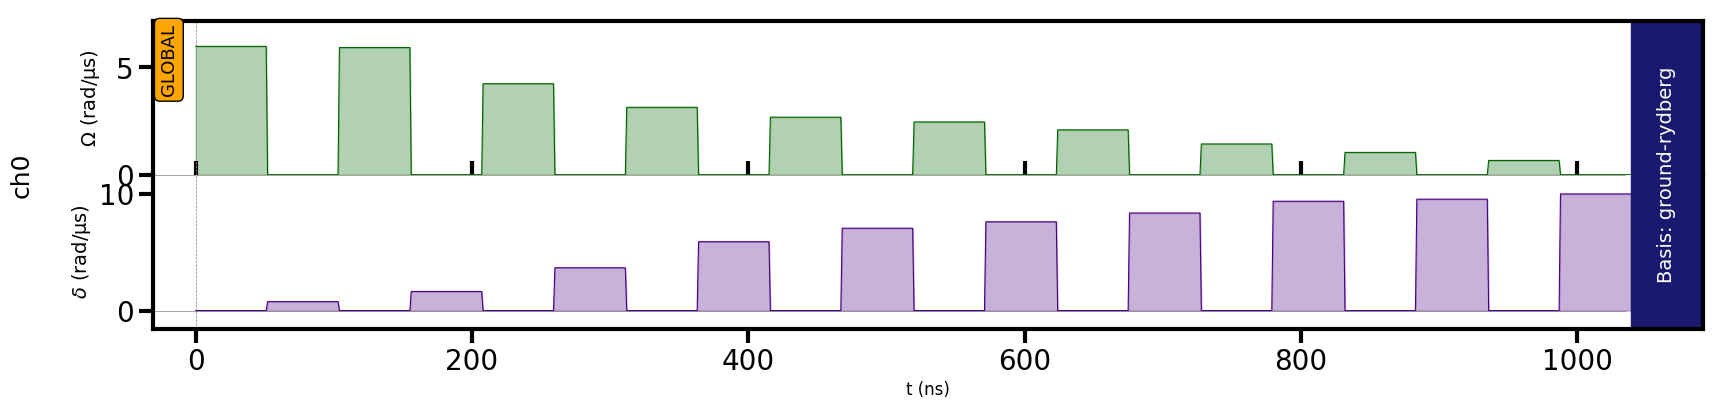

In [27]:
qaoa_seq.draw(fig_name="./Figures/QAOA_seq.png", kwargs_savefig={"bbox_inches":"tight"})

### Visualization of the final state probability distribution

After applying the sequence of QAOA, we can visualize the probability distribution of the solutions. As we see below, two out of the three lowest energy solutions are the most probable to get this indicates that our method has success in finding good solutions.

In [20]:
def plot_distribution(C, sols, ax):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    color_dict = {key: "r" if key in sols else "g" for key in C}
    ax.set_xlabel("bitstrings")
    ax.set_ylabel("counts")
    ax.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical", fontsize=10)

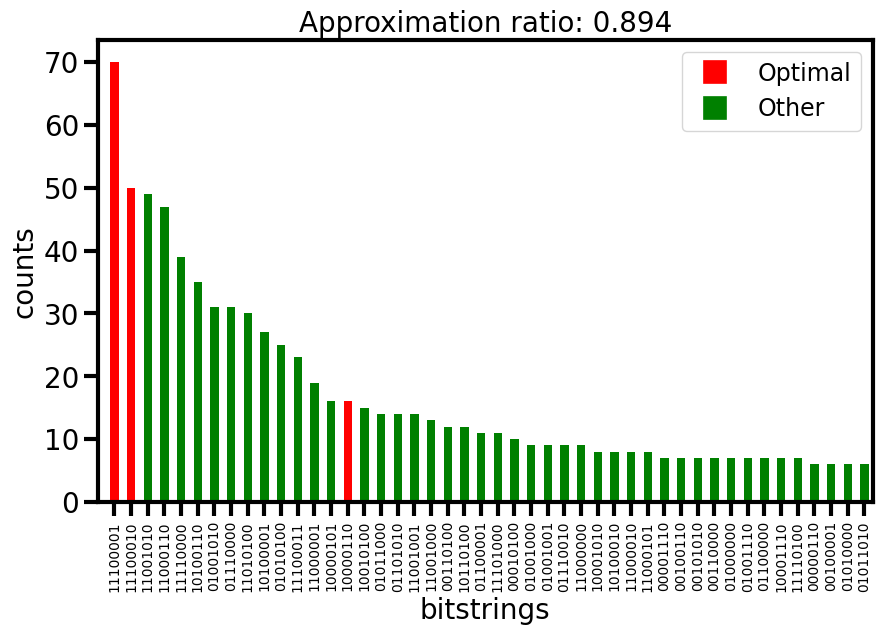

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
r = approximation_ratio(sol_8q_qaoa, Q, cost_min, cost_max)
plot_distribution(sol_8q_qaoa, sols_brute, ax)
ax.plot([],[], marker="s", color="red", label="Optimal", linewidth=0, markersize=16)
ax.plot([],[], marker="s", color="green", label="Other", linewidth=0, markersize=16)
ax.set_title(f"Approximation ratio: {round(r,3)}")
ax.set_xlim(-1,45.5)
ax.legend();

### Cost function for p layers

The Figure below shows the average cost of sampling 1000 times the final probability distribution for different number of layers $p$ of the QAOA algorithm.

In [22]:
cost_qaoa = []
r_qaoa = []
p_range = range(4, 11)
for p in p_range:
    seq = QAOA(tl_bpp["betas"][:p], tl_bpp["gammas"][:p], reg_8q)
    count_dict = run_algorithm(seq)
    cost_qaoa.append(mean_cost(count_dict, Q))
    r_qaoa.append(approximation_ratio(count_dict, Q, cost_min, cost_max))

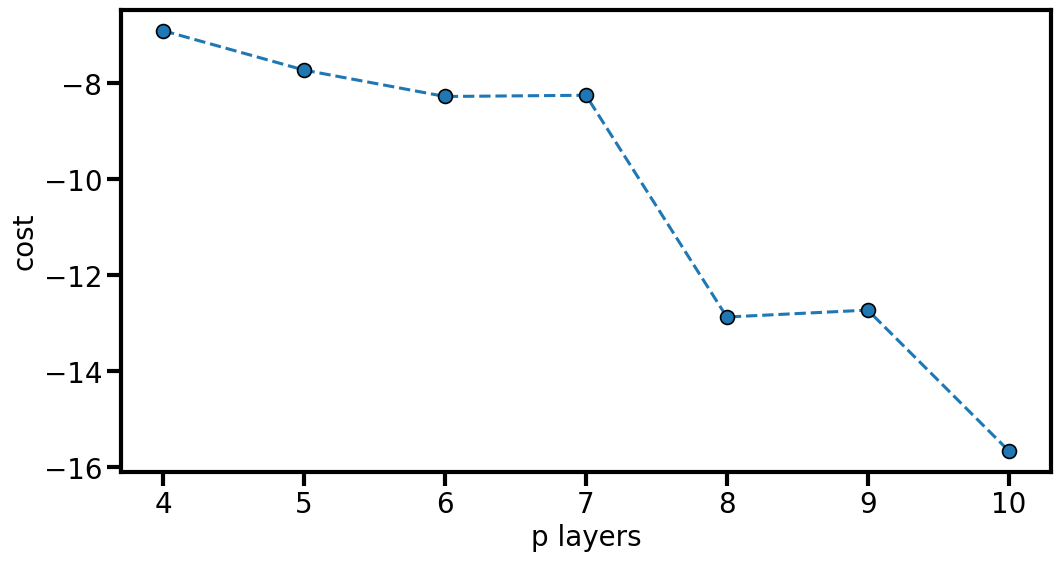

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(p_range, np.array(cost_qaoa), "--o", markeredgecolor="black", markersize=10)
plt.xlabel("p layers")
plt.ylabel("cost")
plt.savefig("./Images/cost_fun_qaoa.png", bbox_inches="tight")

### Approximation ratio of QAOA

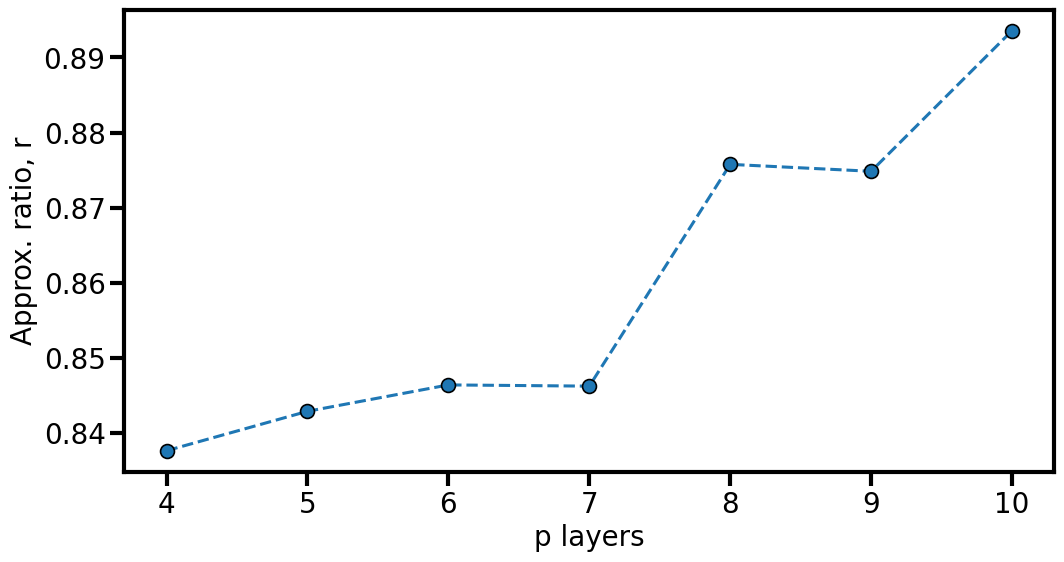

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(p_range, np.array(r_qaoa), "--o", markeredgecolor="black", markersize=10)
plt.xlabel("p layers")
plt.ylabel("Approx. ratio, r")
plt.savefig("./Images/r_qaoa.png", bbox_inches="tight")

# QAA Solution

In the solution of our quantum adiabatic algorithm (QAA), we use the predefined adiabatic pulse and the register we have defined before. In this case, we leave the system to evolve during 4$\mu s$. In this algorithm, we leave the system to evolve slowly enough to remain in states close to the ground state, therefore increasing the probability of getting states with low energy.

In [25]:
def QAA(Omega, reg, delta_0 = -5, delta_f=5, T=4000, backend=Chadoq2):
    """ Quantum Adiabatic Algorithm
    
        Args: 
        
        Omega (float): Maximum amplitude of the Raby frequency in [rad/us]
        reg (pulser.Register): Pulser register with the information of the atoms
        delta_0 (float): Minimum detuning of the protocol [rad/us]
        delta_f (float): Maximum detuning of the protocol [rad/us]
        T (int): time of the annealing protocol in [ns]
        
        Return:
        Sed (pulser.Sequence): sequence with the annealing evolution.
        
    """
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    seq = Sequence(reg, backend)
    seq.declare_channel("ising", "rydberg_global")
    seq.add(adiabatic_pulse, "ising")
    return seq

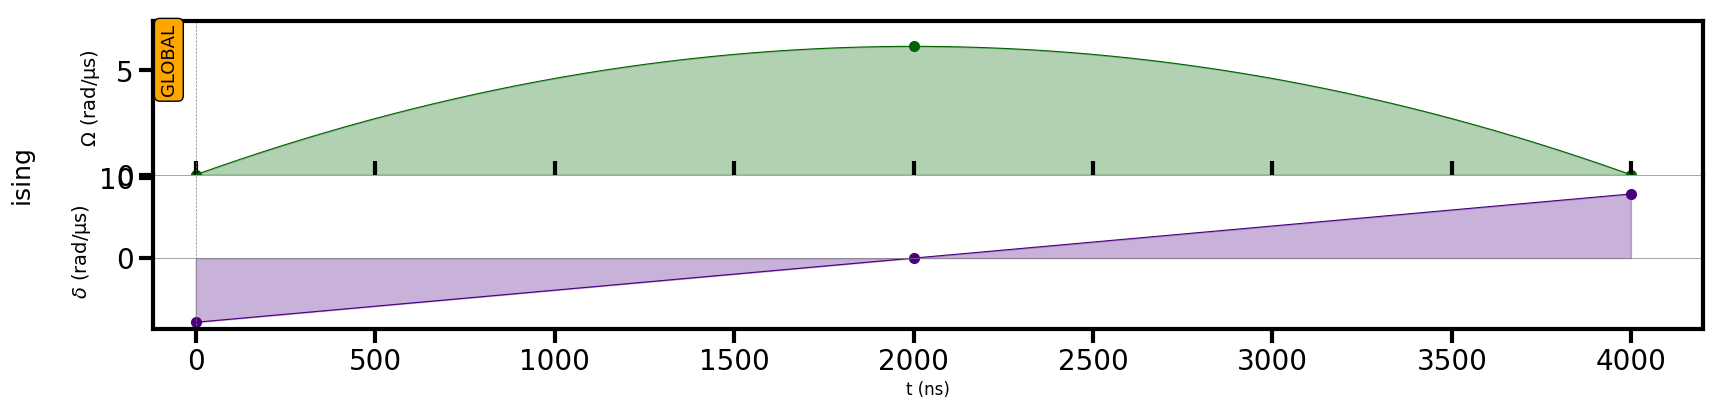

In [26]:
# We choose a median value between the min and the max
Omega = np.median(Q[Q > 0].flatten())
delta_0 = - 8  # just has to be negative
delta_f = - delta_0  # just has to be positive
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

seq_qaa = QAA(Omega, reg_8q, delta_0, delta_f, T)
seq_qaa.draw(fig_name="./Images/QAA_seq.png",kwargs_savefig={"bbox_inches":"tight"})

### Running the QAA algorithm

In [27]:
sol_8q_qaa = run_algorithm(seq_qaa)

### QAA solution visualization for T = 4000 ns

Below, it is shown the solution got using the QAA algorithm for the EVCN with 8 locations. The solution show a large probability of getting the optimal solution and an approximation ratio of 0.97.

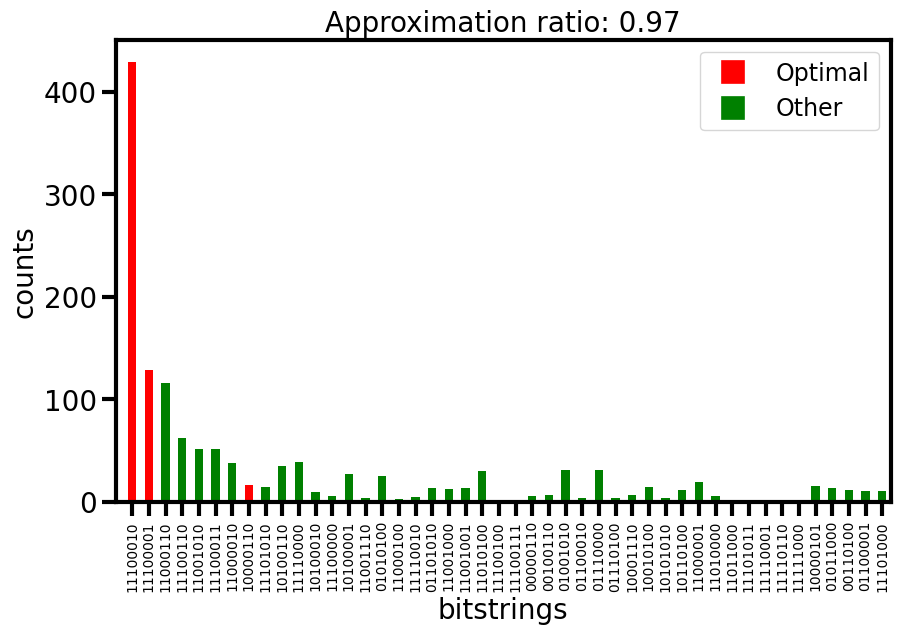

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_distribution(sol_8q_qaa, sols_brute, ax)
ax.plot([],[], marker="s", color="red", label="Optimal", linewidth=0, markersize=16)
ax.plot([],[], marker="s", color="green", label="Other", linewidth=0, markersize=16)
r = approximation_ratio(sol_8q_qaa, Q, cost_min, cost_max)
plot_distribution(sol_8q_qaoa, sols_brute, ax)
ax.set_title(f"Approximation ratio: {round(r,3)}")
ax.set_xlim(-1,45.5)
ax.legend();

## Cost of QAA

The figure below shows the evolution of the average energy of the EVCN for times ranging from 0.4$\mu$s to 10$\mu$s.

In [29]:
cost_qaa = []
r_qaa = []
qaa_T = (np.linspace(400, 10000, 10, dtype=int)//4) * 4
for T in qaa_T :
    seq = QAA(Omega, reg_8q, delta_0=-8, delta_f=8, T=T)
    count_dict = run_algorithm(seq)
    cost_qaa.append(mean_cost(count_dict, Q))
    r_qaa.append(approximation_ratio(count_dict, Q, cost_min, cost_max))

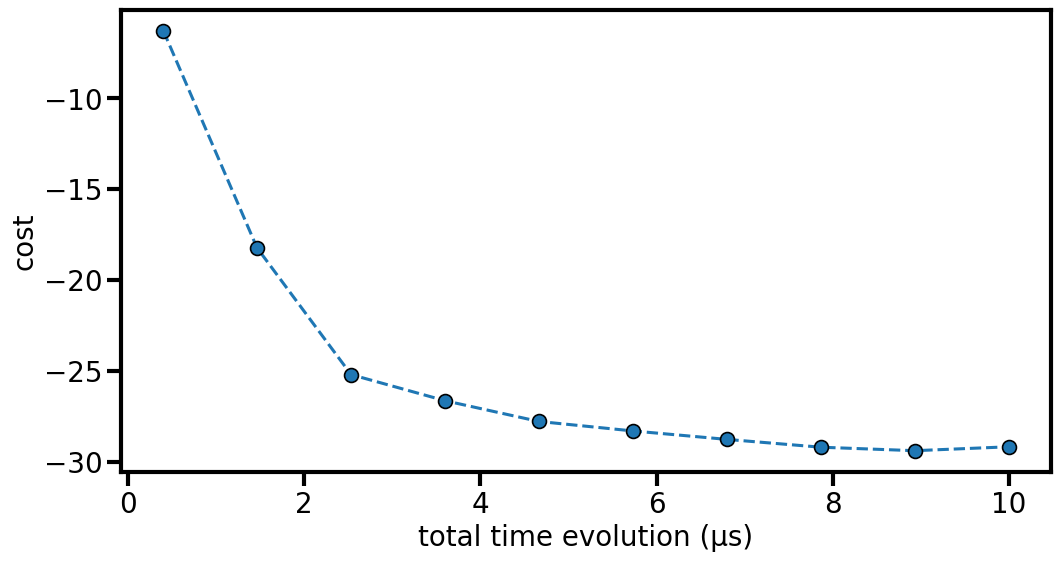

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(qaa_T * 1e-3, np.array(cost_qaa), "--o", markeredgecolor="black", markersize=10)
plt.xlabel("total time evolution (µs)")
plt.ylabel("cost")
plt.savefig("./Images/cost_fun.png", bbox_inches="tight")

### Approximation ratio of QAA

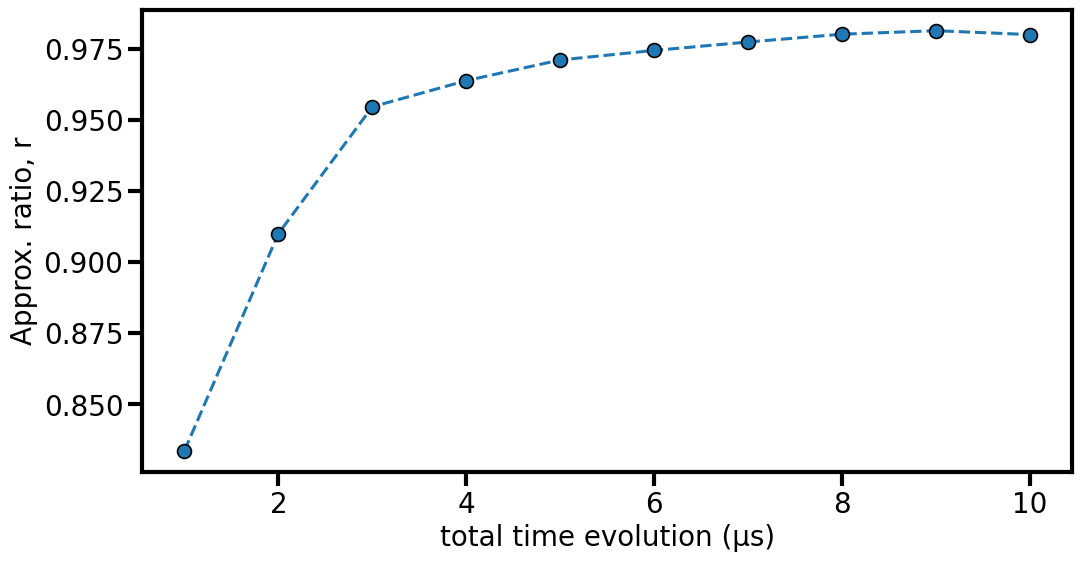

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), np.array(r_qaa), "--o", markeredgecolor="black", markersize=10)
plt.xlabel("total time evolution (µs)")
plt.ylabel("Approx. ratio, r")
plt.savefig("./Images/approx_ratio_qaa.png", bbox_inches="tight")

## Comparison QAOA and QAA for the same evolution time

In [32]:
cost_qaa = []
cost_qaoa = []
r_qaa = []
r_qaoa = []
p_layers = np.arange(4,11)
for p in p_layers:
    seq_qaa = QAA(Omega, reg_8q, delta_0=-8, delta_f=8, T=p*2*52)
    seq_qaoa = QAOA(tl_bpp["betas"][:p], tl_bpp["gammas"][:p], reg_8q)
    count_dict_qaa = run_algorithm(seq_qaa)
    count_dict_qaoa = run_algorithm(seq_qaoa)
    cost_qaa.append(mean_cost(count_dict_qaa, Q))
    r_qaa.append(approximation_ratio(count_dict_qaa, Q, cost_min, cost_max))
    cost_qaoa.append(mean_cost(count_dict_qaoa, Q))
    r_qaoa.append(approximation_ratio(count_dict_qaoa, Q, cost_min, cost_max))

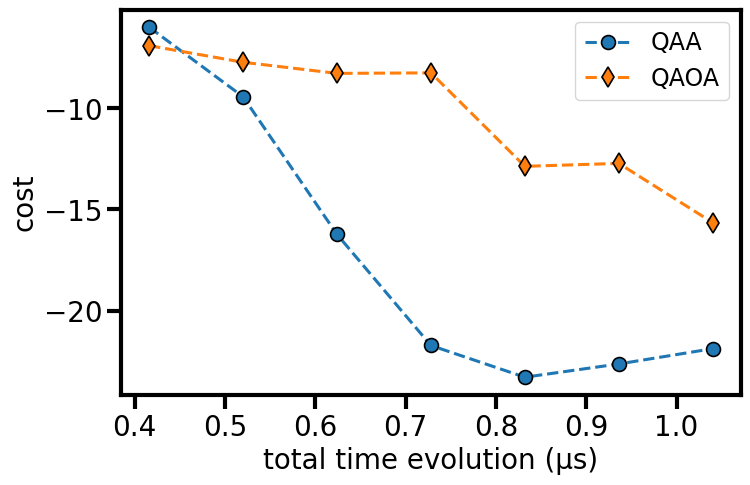

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(4,11)*2*52 * 1e-3, np.array(cost_qaa), "--o", markeredgecolor="black", markersize=10, label="QAA")
plt.plot(np.arange(4,11)*2*52 * 1e-3, np.array(cost_qaoa), "--d", markeredgecolor="black", markersize=10, label="QAOA")

plt.xlabel("total time evolution (µs)")
plt.ylabel("cost")
plt.legend()
plt.savefig("./Images/cost_comparison.png", bbox_inches="tight")

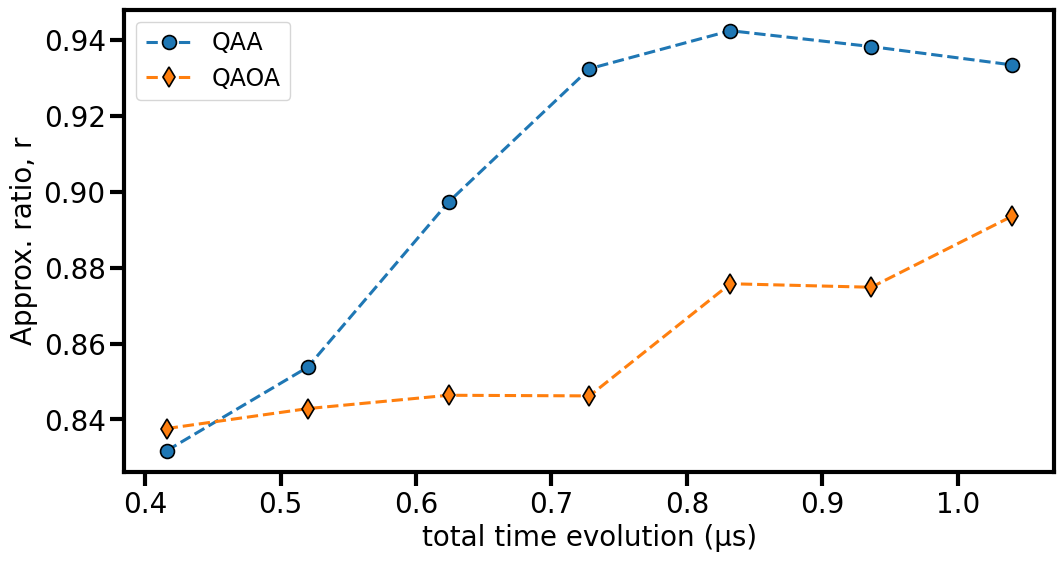

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(4,11)*2*52 * 1e-3, np.array(r_qaa), "--o", markeredgecolor="black", markersize=10, label="QAA")
plt.plot(np.arange(4,11)*2*52 * 1e-3, np.array(r_qaoa), "--d", markeredgecolor="black", markersize=10, label="QAOA")

plt.xlabel("total time evolution (µs)")
plt.ylabel("Approx. ratio, r")
plt.legend()
plt.savefig("./Images/r_comparison.png", bbox_inches="tight")

# Scale of the EVCN

In this section, the scale properties of the EVCN are shown for the quantum and the classical solvers. For the quantum solver, we use the QAOA and QAA algorithm for problem size ranging from 5 to 13 qubits. 10 random cases are selected for each problem size. We show two quantifiers of the quantum algorithms, the probability of finding the 5 best solutions using each quantum solver $p(^*x)$, and the approximation ration $r$. 

In [35]:
def classical_solution(mdl, string: bool = False, solution_limit = 5):
    """
    Get back some specific solutions using CPLEX.
    Args: 
        mdl: (docplex.mp.model): EVCN model 
        string (bool): If the solution is returned as a string or a list. The default is False.
        solution_limit (int): Number of first solutions needed
    Return:
        solutions : Union[str, dict]:The classical solution of the specific problem as a string or a dict.
    """
    model = mdl.copy()
    decision_variables = [var for var in model.iter_binary_vars()]

    # Initialize a list to store all optimal solutions
    optimal_solutions = []

    while True:
        # Solve the current model
        model.solve()
        # Check if a solution is found
        if model.solution is not None:
            # Store the current optimal solution
            optimal_solutions.append("".join(str(round(model.solution.get_value(var))) for var in decision_variables))

            # Add a cut to exclude the current solution
            sol = [var for var in decision_variables if round(model.solution.get_value(var)) == 1] 
            cut = model.sum(sol) <= len(sol) - 1
            model.add_constraint(cut)
        else:
            # No more solutions found
            break

        # Termination condition: reaching a solution limit
        if len(optimal_solutions) >= solution_limit:
            break
    return optimal_solutions

### Setup the problems

In [36]:
registers = defaultdict(dict) # Where the positions of the atoms is saved
energy_case = defaultdict(dict) # value of the optimal cost for each case
optimal_sols = defaultdict(dict) # bitstrings with the optimal solution
Qs = defaultdict(dict) # QUBO matrices Q for the different cases

In [37]:
num_qubits = [5, 6, 7, 8, 9, 10, 11, 12, 13] # different problem size
num_random_cases = 10 # random cases used

for nq in num_qubits:
    print(f" ---------   qubits {nq} --------------")
    grid = round(np.ceil(np.sqrt(nq)))
    G = graph(nq, distance_threshold=1.5) # Graph with the charging locations
    pos = nx.get_node_attributes(G, 'pos') # position of the charging locations
    for kk in range(num_random_cases): # iterate over 'num_random_cases' random cases
        np.random.seed(kk)
        demand_min = 3 # Minimum demand for our model
        demand_max = 14 # maximum demand at each charging loction area
        demand = np.random.choice(range(demand_min, demand_max+1), size=(grid, grid)) # Choosing the demand to be random.
                                                                             # in the future, it will be calculated based on real data
        lambda_ij, Q = set_problem(G, demand) # penalization based on the demand
        Qs[nq][kk] = Q # Saving the QUBO matrix for the random problem
        coords = get_layout(Q, pos, print_output=False) # coordinates of the atoms that represent the QUBO matrix Q

        qubits = dict(enumerate(coords))
        registers[nq][kk] = Register(qubits) # pulser.Register for the atoms' position

        mdl = EVCN(G, lambda_ij) # CPLEX model of the EVCN
        optimal_sols[nq][kk] = classical_solution(mdl, string=True, solution_limit=5) # Getting back the first 5 solutions of the EVCN
        mdl.solve() # Solving the EVCN model
        min_energy = mdl.solution.objective_value # Optimal solution of the EVCN
        max_energy = get_cost_QUBO("1"*mdl.number_of_binary_variables, Q) # The maximum energy for the EVCN is to choose all the atoms
        energy_case[nq][kk] = (round(min_energy,4), round(max_energy,4)) #save minimum and maximum cost of the EVCN
    

 ---------   qubits 5 --------------
 ---------   qubits 6 --------------
 ---------   qubits 7 --------------
 ---------   qubits 8 --------------
 ---------   qubits 9 --------------
 ---------   qubits 10 --------------
 ---------   qubits 11 --------------
 ---------   qubits 12 --------------
 ---------   qubits 13 --------------


## QAOA Solution

For the QAOA solution, we use the transfer learning methodology we presented in previous sections. Therefore, p=10 layers are used with preoptimized values of a BPP obtained in gate based models are transfered to all the random cases we present here. This p=10 only requires $t=1 \mu s$

In [38]:
count_qaoa = defaultdict(list)
r_qaoa = defaultdict(list)
mean_cost_qaoa = defaultdict(list)
for nq in num_qubits:
    print(f" ---------- num_qubits: {nq} ---------")
    for kk in range(num_random_cases):
        seq_qaoa = QAOA(tl_bpp["betas"], tl_bpp["gammas"], registers[nq][kk]) # pulse sequence of QAOA for the given register
        results_dict = run_algorithm(seq_qaoa)
        count_qaoa[nq].append(sum([results_dict[i] for i in optimal_sols[nq][kk]])) # Saving the sampling count of the first 5 optimal solutions
        min_energy, max_energy = energy_case[nq][kk]
        r_qaoa[nq].append(approximation_ratio(results_dict, Qs[nq][kk], min_energy, max_energy)) # saving the approximation ratio
        mean_cost_qaoa[nq].append(mean_cost(results_dict, Qs[nq][kk])) # Saving mean cost of 1000 samples
        
    

 ---------- num_qubits: 5 ---------
 ---------- num_qubits: 6 ---------
 ---------- num_qubits: 7 ---------
 ---------- num_qubits: 8 ---------
 ---------- num_qubits: 9 ---------
 ---------- num_qubits: 10 ---------
 ---------- num_qubits: 11 ---------
 ---------- num_qubits: 12 ---------
 ---------- num_qubits: 13 ---------


## QAA Solution

For the QAA solution, we use two different annealing times $4\mu s$ and $10 \mu s$ to see if there are differences in the mean cost and optimal sampling rate between both times. We use the same annealing procedure presented above.

### T = 4 $\mu$s

In [39]:
count_qaa_T4 = defaultdict(list)
r_qaa_T4 = defaultdict(list)
mean_cost_qaa_T4 = defaultdict(list)

for nq in num_qubits:
    print(f"num_qubits: {nq}")
    for kk in range(num_random_cases):
        Omega = np.median(Qs[nq][kk][Qs[nq][kk] > 0].flatten()) # Rabi frequency based on the median value of the matrix Q of the QUBO
        seq_qaa = QAA(Omega, registers[nq][kk]) # pulse sequence of QAA for the given register
        results_dict = run_algorithm(seq_qaa) # running the QAA sequence on the QuTiP simulator
        count_qaa_T4[nq].append(sum([results_dict[i] for i in optimal_sols[nq][kk]])) # saving results about 1000 samplings
        min_energy, max_energy = energy_case[nq][kk]
        r_qaa_T4[nq].append(approximation_ratio(results_dict, Qs[nq][kk], min_energy, max_energy))# saving the approximation ratio of the samples
        mean_cost_qaa_T4[nq].append(mean_cost(results_dict, Qs[nq][kk])) # save the mean cost of the EVCN
        

num_qubits: 5
num_qubits: 6
num_qubits: 7
num_qubits: 8
num_qubits: 9
num_qubits: 10
num_qubits: 11
num_qubits: 12
num_qubits: 13


### T = 10 $\mu$s

In [40]:
count_qaa_T10 = defaultdict(list)
r_qaa_T10 = defaultdict(list)
mean_cost_qaa_T10 = defaultdict(list)
for nq in num_qubits:
    print(f"num_qubits: {nq}")
    for kk in range(num_random_cases):
        Omega = np.median(Qs[nq][kk][Qs[nq][kk] > 0].flatten())
        seq_qaa = QAA(Omega, registers[nq][kk], T=10000)
        results_dict = run_algorithm(seq_qaa)
        count_qaa_T10[nq].append(sum([results_dict[i] for i in optimal_sols[nq][kk]]))
        min_energy, max_energy = energy_case[nq][kk]
        r_qaa_T10[nq].append(approximation_ratio(results_dict, Qs[nq][kk], min_energy, max_energy))
        mean_cost_qaa_T10[nq].append(mean_cost(results_dict, Qs[nq][kk]))

num_qubits: 5
num_qubits: 6
num_qubits: 7
num_qubits: 8
num_qubits: 9
num_qubits: 10
num_qubits: 11
num_qubits: 12
num_qubits: 13


## Plot quantum algorithms scaling solutions 

For the plots shown below, the error bars represent the **quartiles** Q1 to Q2 and Q2 to Q3 and the marker is the **median** value over the 10 random cases. The information we can get at this scale is still too short to conclude about the scaling in the neutral atoms platform. But, the data shows good characteristics that we want to highlight:

    1) Both methods QAOA and QAA show good characteristics to identify the optimal solution. This can be seen in the figure below, where the probability of finding the 5 best solutions remains higher than a quadratic speedup (The advantage of Grover's algorithm in dashed line).

    2) There is an improvement in the approximation ratio for QAA changing T from 4 us to 10 us, but the difference is not too big. We need larger cases to see how they start to deviate. For both cases of QAA the approximation ration keeps above 0.9 while in QAOA it keeps above 0.8 without optimization.

In [41]:
def add_errorbar(data, ax, color, name, scaling=1000, num_random=5):
    median = []
    for nq in data.keys():
        data_nq = np.array(data[nq])/scaling # Scaling when talking about shots
        quartiles = np.percentile(data_nq, [25, 50, 75]) # Quartiles Q1 - Q2 - Q3
        median.append(quartiles[1])
        ax.errorbar(nq, quartiles[1], yerr=[[quartiles[1] - quartiles[0]], [quartiles[2] - quartiles[1]]], marker="o", markeredgecolor="black", color=color)
    ax.plot(data.keys(), median, color=color, label=name)

### Probability of finding the first 5 optimal solutions $p(^*x)$for QAOA and QAA

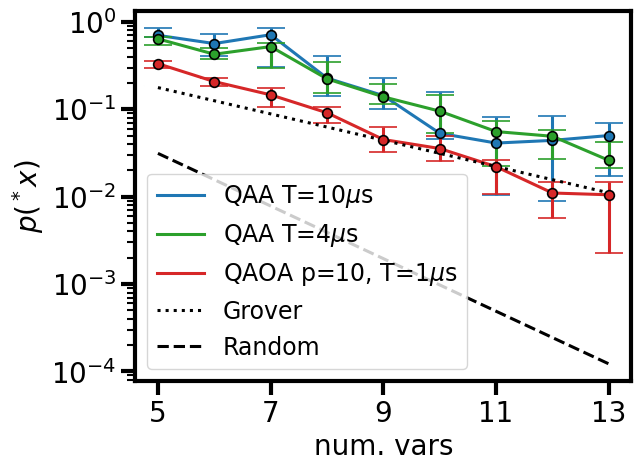

In [42]:
fig, ax = plt.subplots()
add_errorbar(count_qaa_T10, ax=ax, color="tab:blue", name="QAA T=$10\mu$s")
add_errorbar(count_qaa_T4, ax=ax, color="tab:green", name="QAA T=$4\mu$s")
add_errorbar(count_qaoa, ax=ax, color="tab:red", name="QAOA p=10, T=1$\mu$s")
ax.plot(num_qubits, [1/2**(i/2) for i in num_qubits], linestyle=":", color="black", label="Grover")
ax.plot(num_qubits, [1/2**(i) for i in num_qubits], linestyle="--", color="black", label="Random")
ax.set_yscale("log")
ax.legend()
ax.set_ylabel("$p(^* x)$")
ax.set_xlabel("num. vars")
ax.set_xticks([5, 7, 9, 11, 13])
fig.savefig("scaling_factor.png", bbox_inches="tight")

### Approximation ratio $r$ for QAOA and QAA

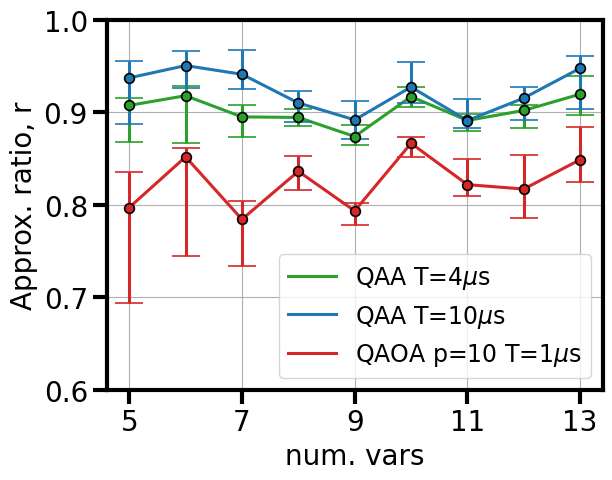

In [43]:
fig, ax = plt.subplots()
add_errorbar(r_qaa_T4, scaling=1, ax=ax, color="tab:green", name="QAA T=$4\mu$s")
add_errorbar(r_qaa_T10, scaling=1, ax=ax, color="tab:blue", name="QAA T=$10\mu$s")
add_errorbar(r_qaoa, scaling=1, ax=ax, color="tab:red", name="QAOA p=10 T=1$\mu$s")

ax.legend()
ax.set_ylabel("Approx. ratio, r")
ax.set_xlabel("num. vars")
ax.set_xticks([5, 7, 9, 11, 13]);
ax.set_yticks([0.6, 0.7, 0.8, 0.9, 1])
ax.grid()
# fig.savefig("scaling_factor.png", bbox_inches="tight")

### Mean cost of all samplings 

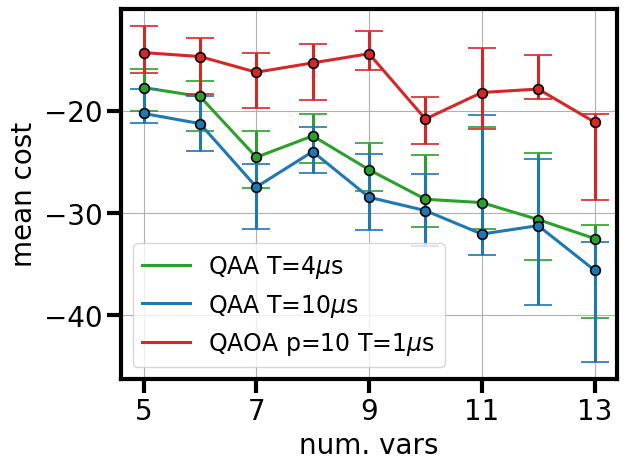

In [44]:
fig, ax = plt.subplots()
add_errorbar(mean_cost_qaa_T4, scaling=1, ax=ax, color="tab:green", name="QAA T=$4\mu$s")
add_errorbar(mean_cost_qaa_T10, scaling=1, ax=ax, color="tab:blue", name="QAA T=$10\mu$s")
add_errorbar(mean_cost_qaoa, scaling=1, ax=ax, color="tab:red", name="QAOA p=10 T=1$\mu$s")
ax.legend()
ax.set_ylabel("mean cost")
ax.set_xlabel("num. vars")
ax.set_xticks([5, 7, 9, 11, 13]);
ax.grid()

# Docplex solution

Finally, we did simulation of the EVCN model using classical computation. To this end, we select CPLEX because of being widely use in combinatorial optimization for business purposes. The EVCN problem is harder to solve than the MIS, and already with 1000 variables (the limit of CPLEX free version allows) the time to solution grows up to 30 seconds. If we take this solutions as an indication of the scaling time of the EVCN it will take around 3.6 hours for a 2000 variables solution and 54.4 years for 4000 variables on a MacBook Pro M1 with 8 cores. 

In [45]:
num_vars = [5, 10, 20, 50, 100, 200, 500, 700, 1000]
total_time_evcn = defaultdict(list)
total_time_mis = defaultdict(list) # MIS
num_random_cases = 10

for nq in num_vars:
    print(f"qubits {nq}")
    for kk in range(num_random_cases):
        grid = round(np.ceil(np.sqrt(nq)))
        G = graph(nq, distance_threshold=1.5)
        pos = nx.get_node_attributes(G, 'pos')

        mdl = MIS(G)
        it = time.time()
        mdl.solve()
        ft = time.time() - it
        total_time_mis[nq].append(ft)

        np.random.seed(kk)
        demand_min = 3
        demand_max = 14
        demand = np.random.choice(range(demand_min, demand_max+1), size=(grid, grid)) # Choosing the demand to be random, in the future
                                                                   # it will be calculated based on real data

        lambda_ij, Q = set_problem(G, demand)
        mdl = EVCN(G, lambda_ij)
        it = time.time()
        mdl.solve()
        ft = time.time() - it
        total_time_evcn[nq].append(ft)
        
        

qubits 5
qubits 10
qubits 20
qubits 50
qubits 100
qubits 200
qubits 500
qubits 700
qubits 1000


### Comparison time to solution EVCN vs. MIS

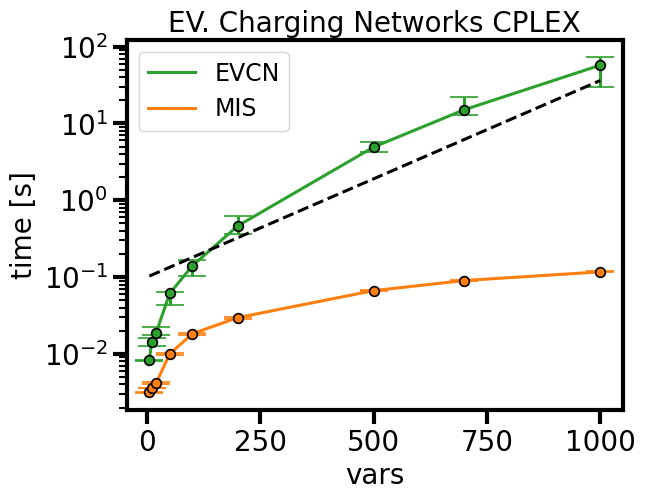

In [47]:
fig, ax = plt.subplots()
add_errorbar(total_time_evcn, scaling=1, ax=ax, color="tab:green", name="EVCN")
add_errorbar(total_time_mis, scaling=1, ax=ax, color="tab:orange", name="MIS")

ax.plot(num_vars, [0.1 * 2**(0.0085*i) for i in num_vars], color="black", linestyle="--")
ax.set_ylabel("time [s]")
ax.set_xlabel("vars")
ax.set_yscale("log")
ax.legend()
ax.set_title("EV. Charging Networks CPLEX")
fig.savefig("./Figures/CPLEX_time.png", bbox_inches="tight")

### Estimation of the time to solution using CPLEX for larger problem size

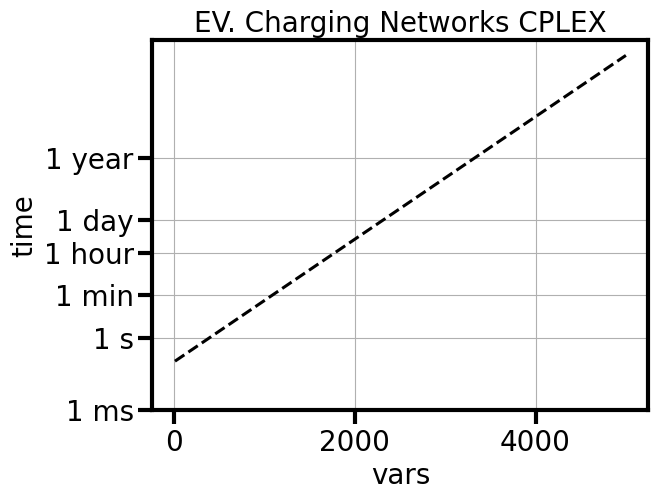

In [48]:
fig, ax = plt.subplots()
num_vars = [10, 100, 200, 500, 1000, 2000, 5000]
ax.plot(num_vars, [0.1 * 2**(0.0085*i) for i in num_vars], color="black", linestyle="--")
ax.set_ylabel("time")
ax.set_xlabel("vars")
ax.set_yscale("log")
ax.set_yticks([1e-3, 1, 60, 3600, 3600*24, 3600*24*365])
ax.set_yticklabels(["1 ms", "1 s", "1 min", "1 hour", "1 day", "1 year"])
ax.set_title("EV. Charging Networks CPLEX")
ax.grid()
fig.savefig("./Figures/scaling_assumption.png", bbox_inches="tight")

# Conclusions

We have presented the EVCN problem, a combinatorial optimization problem for the electric vehicle charging network election. It searches for the optimal allocation of charging stations that satisfies different characteristics in the election of locations such as population density, traffic patterns, existing infrastructure, and EV adoption rates. The model has been shown to be hard to solve using a classical optimizer compared to the MIS version of the same problem which only considers the distance between charging station locations. Additionally, this problem is perfectly tailored to the neutral atoms device of Pasqal, where atoms represent possible charging station locations, and the proximity of the represents the distance between charging station locations and the other factors mentioned previously.

The solutions to the problem using quantum algorithms have been shown to give approximation ratios above 0.9 for the QAA algorithm for up to 13 qubits using an annealing time of $4 \mu s$, and an approximation ratio of 0.8 for QAOA with p=10 (time = $1\mu s$). In terms of the probability of finding optimal solutions, the QAA algorithm keeps above the quadratic speedup and the QAOA with the transfer learning technique in the same range of quadratic speedup. These two characteristics make us optimistic about this application, and we are ahead to test it on real hardware and a large number of qubits to have a stronger point about the scalability of the quantum algorithms.

# Future Work 

We anticipate that with generation 2 of the Pasqal machine, we will be able to encode larger problem sizes and with higher precision in the representation of the QUBO matrix $Q$ of the EVCN. The 3D layout of that generation will mean a jump in precision.

However, for this problem to be meaningful at the production scale more atoms will be needed to surpass the classical solution limit. We envision being able to present solutions for EVCN with a grid size of 1000 x 1000, to this end, we will use a hybrid algorithm that solves small sections of the 1000 x 1000 grids using quantum computation and present them as the starting point of a classical heuristic algorithm such as simulate annealing to find good enough solutions of the problem. 

We have seen that the classical algorithm already with 4000 variables requires 54 years to find the solution (this cannot be taken as a near-accurate estimation but helps in our statement). Let's think that it will take around 5 days on an HPC system to give a good enough solution for the 4000 variables, so to find the solution of a 100 x 100 grid (needed for a medium size city) we will need (100 x 100) / 4000 ~ 3 runs, this means 3 x 5 = 15 days time to find the initial guess for the heuristic algorithm. On the other hand, a neutral atom device with the 4000 variables and with a sampling ratio of 10 solutions per second will give us an initial guess solution of 3 x (1/10) ~ 0.3 seconds (we haven't done assumptions of the annealing time but as it is in the order of $\mu s$ we don't see a large overhead because of this parameter).

## Example of a grid size of 100 x 100 in the city of Dallas

The city of Dallas has a 

In [103]:
grid_size = 100
points = np.arange(grid_size ** 2, dtype=int)
pos = []
for i in points:
    pos.append([i // grid_size, i % grid_size])
pos = np.array(pos)

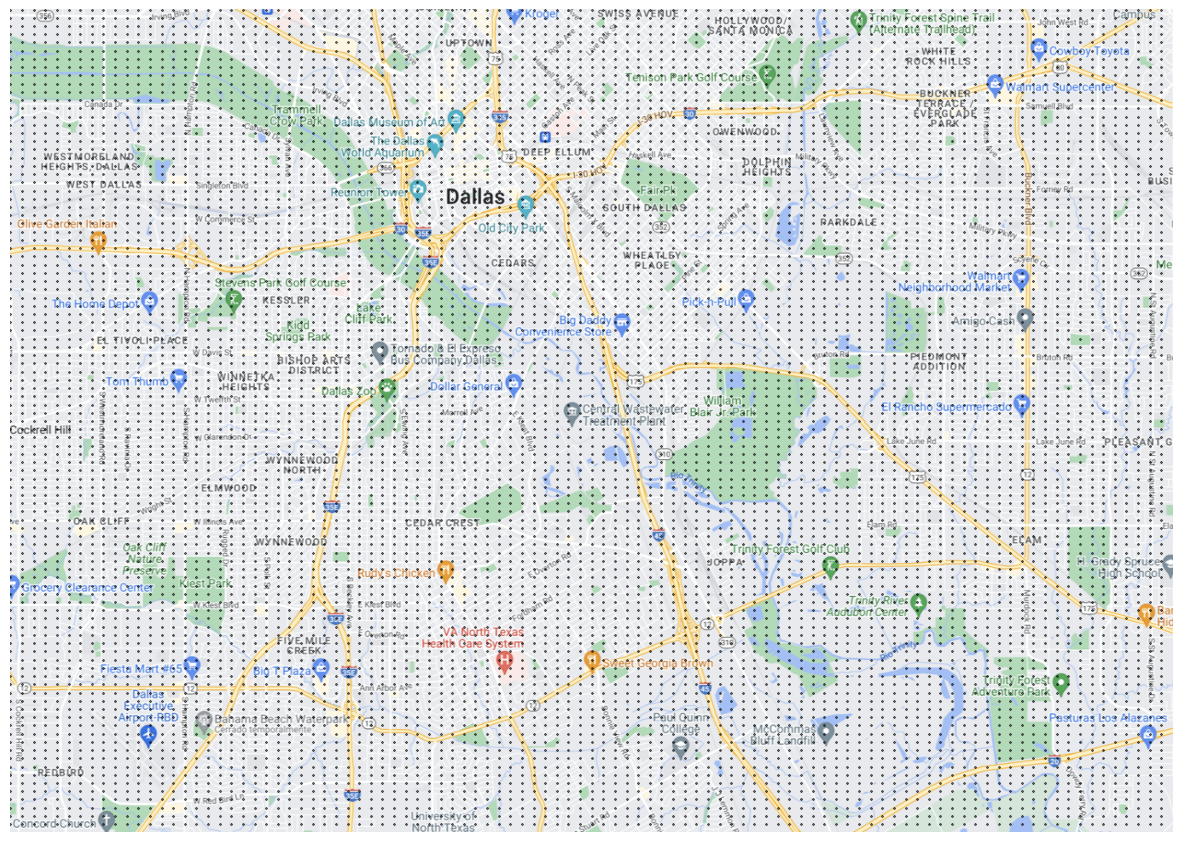

In [107]:
fig, ax = plt.subplots(figsize=(15,15))
image = plt.imread('Dallas_map.png')
shape = image.shape
ax.imshow(image)
for i in range(grid_size ** 2):
    ax.plot(pos[i][0]*shape[1]/grid_size, pos[i][1]*shape[0]/grid_size, marker="o", markersize=0.5, linewidth=0, color="black");
ax.axis('off');
fig.savefig("mid_size_city.png", bbox_inches="tight")